<a href="https://colab.research.google.com/github/alimoradi296/DeepLearning/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt


#LOAD MNIST DATA

In [ ]:
(ds_train,ds_test),ds_info=tfds.load('mnist',
                                     split=['train','test'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True)
batch_size=256

def preprocess(image,label):
  image=tf.cast(image,dtype=tf.float32)
  image=image/255.
  return image,image

ds_train.map(preprocess)
ds_train.cache()
ds_train=ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train=ds_train.batch(batch_size)

ds_test=ds_test.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test.map(preprocess_with_label).batch(1000)



#Building Autoencoder

In [ ]:
def encoder(z_dim):
  inputs=layers.Input(shape=[28,28,1])
  x=inputs
  x=Conv2D(filters=8,kernel_size=(3,3),strides=2,padding='same',activation='relu')(x)
  x=Conv2D(filters=8,kernel_size=(3,3),strides=1,padding='same',activation='relu')(x)
  x=Conv2D(filters=8,kernel_size=(3,3),strides=2,padding='same',activation='relu')(x)
  x=Conv2D(filters=8,kernel_size=(3,3),strides=1,padding='same',activation='relu')(x)
  x=Flatten()(x)
  out=Dense(units=z_dim,activation='relu')(x)
  return Model(inputs=inputs,outputs=out,name='encoder')




In [ ]:
def decoder(z_dim):
  inputs=layers.Input(shape=[z_dim])
  x=inputs

  x=Dense(units=7*7*64,activation='relu')(x)
  x=Reshape((7,7,64))(x)

  x=Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',activation='relu')(x)
  x=UpSampling2D((2,2))(x)

  x=Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same',activation='relu')(x)
  x=UpSampling2D((2,2))(x)

  out=Conv2D(filters=1,kernel_size=(3,3),strides=1,padding='same',activation='sigmoid')(x)
  return Model(inputs,out,name='decoder')






In [ ]:
class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = encoder(z_dim)
        self.decoder = decoder(z_dim)

        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = Model(model_input, model_output)



In [ ]:
autoencoder = Autoencoder(z_dim=10)

In [ ]:
def Encoder(z_dim):
    inputs  = layers.Input(shape=[28,28,1])

    x = inputs
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    out = Dense(z_dim)(x)

    return Model(inputs=inputs, outputs=out, name='encoder')

def Decoder(z_dim):
    inputs  = layers.Input(shape=[z_dim])
    x = inputs
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7,7,64))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)

    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)

    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)

    #return out
    return Model(inputs=inputs, outputs=out, name='decoder')


In [ ]:
autoencoder = Autoencoder(z_dim=10)

In [ ]:
import os
model_path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok=True)

checkpoint = ModelCheckpoint(model_path,
                             monitor= "val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode= "auto",
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss",
                      mode= "auto",
                      patience = 5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4)),
    #metrics=[tf.keras.losses.BinaryCrossentropy()])
autoencoder.model.fit(ds_train, validation_data=ds_test,
                epochs = 100, callbacks = callbacks_list)


Epoch 1/100
233/235 [============================>.] - ETA: 0s - loss: 20.3331
Epoch 1: val_loss improved from inf to 0.35797, saving model to ./models/autoencoder.h5
235/235 [==============================] - 8s 30ms/step - loss: 20.3343 - val_loss: 0.3580
Epoch 2/100
233/235 [============================>.] - ETA: 0s - loss: 20.2630
Epoch 2: val_loss did not improve from 0.35797
235/235 [==============================] - 7s 30ms/step - loss: 20.2774 - val_loss: 0.3901
Epoch 3/100
233/235 [============================>.] - ETA: 0s - loss: 20.2725
Epoch 3: val_loss did not improve from 0.35797
235/235 [==============================] - 8s 32ms/step - loss: 20.2774 - val_loss: 0.3964
Epoch 4/100
233/235 [============================>.] - ETA: 0s - loss: 20.2932
Epoch 4: val_loss did not improve from 0.35797
235/235 [==============================] - 8s 33ms/step - loss: 20.2774 - val_loss: 0.4000
Epoch 5/100
233/235 [============================>.] - ETA: 0s - loss: 20.2802
Epoch 5: val

8/8 [==============================] - 0s 3ms/step


<ipython-input-51-5a3db224292b>:19: MatplotlibDeprecationWarning: The 'renderer' parameter of tight_layout() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'renderer', they should be pass as keyword, not positionally.
  f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)


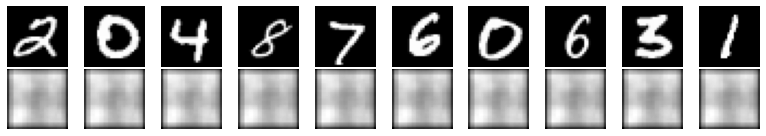

In [ ]:
images, labels = next(iter(ds_test))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()



In [ ]:
autoencoder_2 = Autoencoder(z_dim=2)

early = EarlyStopping(monitor= "val_loss",
                      mode= "auto",
                      patience = 5)

callbacks_list = [early]

autoencoder_2.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

autoencoder_2.model.fit(ds_train, validation_data=ds_test,
                epochs = 50, callbacks = callbacks_list)


Epoch 1/50
235/235 [==============================] - 8s 29ms/step - loss: 20.3189 - val_loss: 0.5302
Epoch 2/50
235/235 [==============================] - 7s 28ms/step - loss: 20.2774 - val_loss: 0.5702
Epoch 3/50
235/235 [==============================] - 7s 29ms/step - loss: 20.2774 - val_loss: 0.5770
Epoch 4/50
235/235 [==============================] - 7s 28ms/step - loss: 20.2774 - val_loss: 0.5808
Epoch 5/50
235/235 [==============================] - 7s 29ms/step - loss: 20.2774 - val_loss: 0.5835
Epoch 6/50
235/235 [==============================] - 7s 29ms/step - loss: 20.2774 - val_loss: 0.5856


4/4 [==============================] - 0s 3ms/step


<ipython-input-53-730f3e2ad46c>:14: MatplotlibDeprecationWarning: The 'renderer' parameter of tight_layout() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'renderer', they should be pass as keyword, not positionally.
  f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)


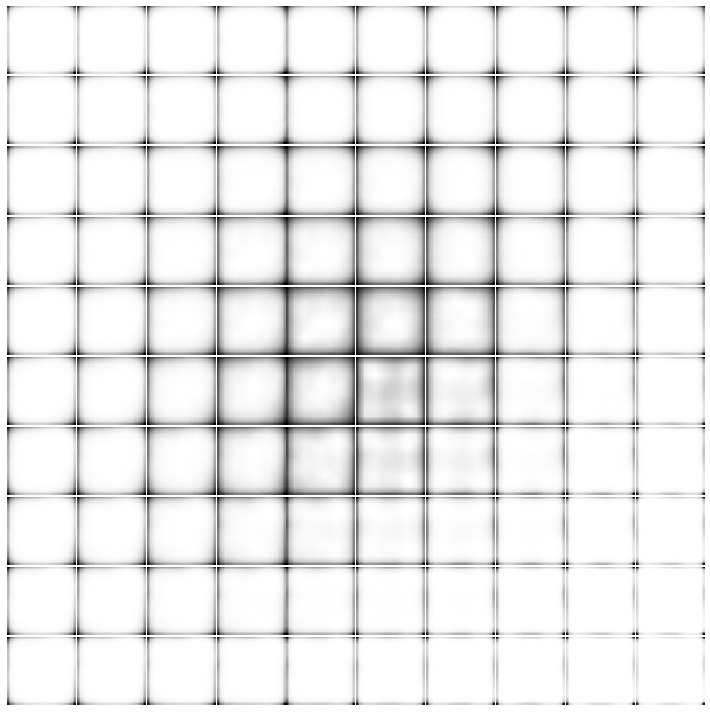

In [ ]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-5, 5, 1.) for z1 in np.arange(-5, 5, 1.)])
images = autoencoder_2.decoder.predict(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual



In [ ]:
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = autoencoder_2.decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')



interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…